# XAI Metrics based on Local Feature Importance

In [2]:
from holisticai.utils import BinaryClassificationProxy
from sklearn.ensemble import RandomForestClassifier

from holisticai.datasets import load_dataset

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

from holisticai.utils.feature_importances import compute_permutation_feature_importance, compute_conditional_permutation_feature_importance, compute_shap_feature_importance
from holisticai.explainability.metrics.local_feature_importance import classification_local_feature_importance_explainability_metrics
from holisticai.utils.data_preprocessor import simple_preprocessor
from holisticai.efficacy.metrics import classification_efficacy_metrics

# Binary Classification (Adult Dataset)

In [3]:
dataset = load_dataset('adult', preprocessed=False)
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
dataset

DatasetDict({
    train: <holisticai.datasets._dataset.Dataset object at 0x7f059e29c590>,
    test: <holisticai.datasets._dataset.Dataset object at 0x7f0534b5b6d0>
})

In [4]:
train = dataset['train']
test = dataset['test']
Xt_train, Xt_test, yt_train, yt_test = simple_preprocessor(train['X'], test['X'], train['y'], test['y'])

**Define a Proxy Model**: A proxy model enables standardized use of your model across multiple functions. You simply provide the essential components required for each type of proxy. For instance, in binary classification, only the predict function, predict_proba function, and the labels are needed.

In [5]:
model = RandomForestClassifier(random_state=42)
model.fit(Xt_train, yt_train)
proxy = BinaryClassificationProxy(predict=model.predict, predict_proba=model.predict_proba, classes=model.classes_)
proxy

{"dtype":"Proxy Model","attributes":{"Learning Task":"binary_classification","Classes":[0,1]}}

# Efficacy Metrics

In [6]:
y_pred_test = proxy.predict(Xt_test)
efficacy_metrics = classification_efficacy_metrics(yt_test, y_pred_test)
efficacy_metrics

,Value,Reference
Metric,,
Accuracy,0.849198,1
Balanced Accuracy,0.769211,1
Precision,0.725174,1
Recall,0.613255,1
F1-Score,0.664535,1


# Local Feature Importance

In [7]:
local_importances = compute_shap_feature_importance(X=Xt_train, proxy=proxy, max_samples=1000, random_state=42)
local_importances

PermutationExplainer explainer: 1001it [03:29,  4.51it/s]                          


{"dtype":"Local Feature Importance","attributes":{"Number of Features":96,"Number of Instances":1000}}

# Local Feature Importance XAI Metrics

**Rank Consistency**: Evaluates the consistency of feature importance rankings across different subsets (e.g., prediction labels in classification tasks).

**Importance Stability**: Measures the average variability in feature importance values for each feature. Higher values indicate more complex behavior.

In [8]:
local_metrics = classification_local_feature_importance_explainability_metrics(local_importances)
local_metrics

,Value,Reference
Rank Consistency,0.159492,0
Importance Stability,0.097573,0


```plot_local_feature_importances_stability```  displays the top average local feature importances and the importance stability score for each feature.

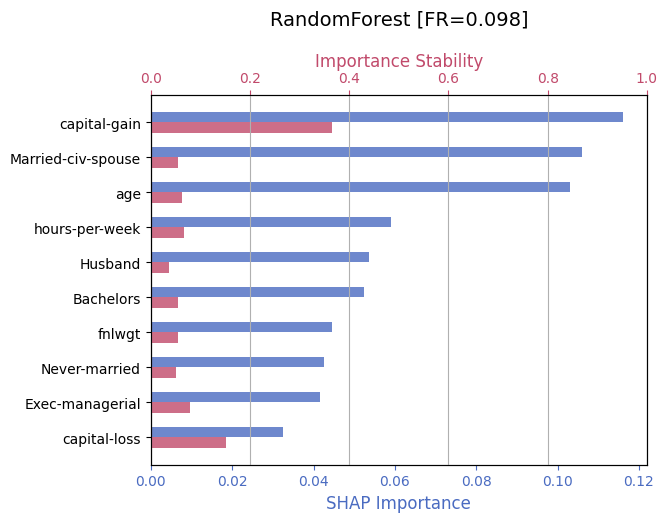

In [9]:
from holisticai.explainability.plots import plot_local_feature_importances_stability

top_n=10
plot_local_feature_importances_stability(local_importances, top_n=top_n, model_name='RandomForest')

The function ```plot_ranking_consistency``` displays the ranking variance of each feature in a plot of instance versus feature. Features are sorted from lowest ranking variance (white) to highest variance (blue).

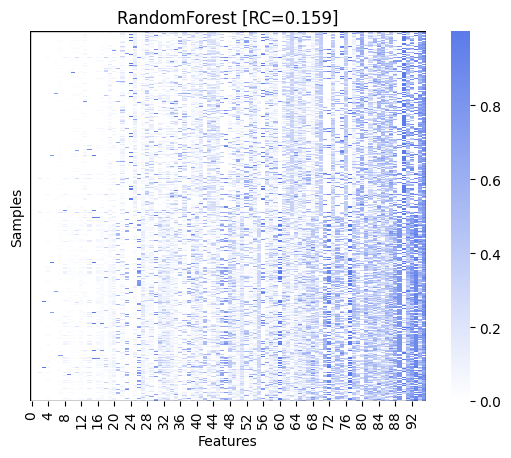

In [10]:
from holisticai.explainability.plots import plot_ranking_consistency

plot_ranking_consistency(local_importances, "RandomForest")

# Regression (US Crime Dataset)

In [11]:
ds = load_dataset('us_crime', preprocessed=False)
dataset = ds.train_test_split(test_size=0.2, random_state=42)

train = dataset['train']
test = dataset['test']

Xt_train, Xt_test, yt_train, yt_test = simple_preprocessor(train['X'], test['X'], train['y'], test['y'], categorical_types=['object'], model_type='regression', only_numerics=True)

Train and create proxy

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from holisticai.utils import RegressionProxy
from holisticai.efficacy.metrics import regression_efficacy_metrics
from holisticai.utils import concatenate_metrics

model = GradientBoostingRegressor()
model.fit(Xt_train, yt_train)
proxy = RegressionProxy(predict=model.predict)

y_pred_test = model.predict(Xt_test)
efficacy_metrics =regression_efficacy_metrics(yt_test, y_pred_test)
efficacy_metrics

,Value,Reference
Metric,,
RMSE,1.387184e-01,0
MAE,8.933868e-02,0
MAPE,1.571975e+12,0
Max Error,7.582146e-01,0
SMAPE,2.350659e-01,0


compute local feature importance

In [13]:
local_importances = compute_shap_feature_importance(X=Xt_train, proxy=proxy, max_samples=1000, random_state=42)
local_importances

PermutationExplainer explainer: 1001it [00:57, 14.68it/s]                          


{"dtype":"Local Feature Importance","attributes":{"Number of Features":101,"Number of Instances":1000}}

In [14]:
from holisticai.explainability.metrics.local_feature_importance import regression_local_feature_importance_explainability_metrics

local_metrics = regression_local_feature_importance_explainability_metrics(local_importances)
local_metrics

,Value,Reference
Rank Consistency,0.132485,0
Importance Stability,0.018467,0


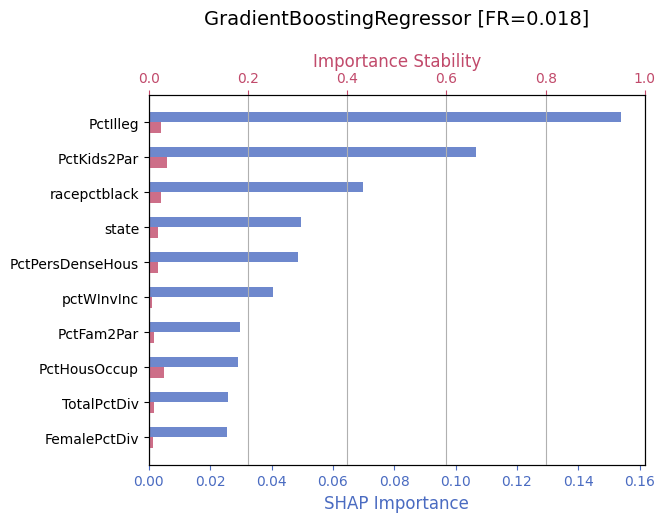

In [15]:
from holisticai.explainability.plots import plot_local_feature_importances_stability

top_n=10
plot_local_feature_importances_stability(local_importances, top_n=top_n, model_name='GradientBoostingRegressor')

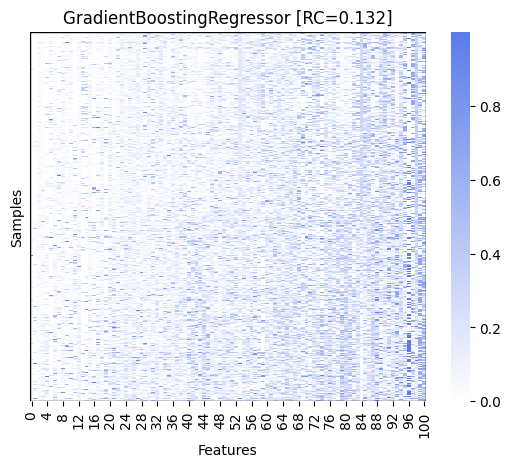

In [16]:
from holisticai.explainability.plots import plot_ranking_consistency

plot_ranking_consistency(local_importances, "GradientBoostingRegressor")